In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/processed/train.csv')

C:\Users\LEGION\AppData\Local\Temp\ipykernel_10320\247379734.py:1: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/train.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606311 entries, 0 to 4606310
Data columns (total 48 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date                                  object 
 1   customer_id                           int64  
 2   employee_index                        object 
 3   country_of_residence                  object 
 4   gender                                object 
 5   age                                   object 
 6   registration_date                     object 
 7   new_customer                          float64
 8   seniority                             object 
 9   primary_customer                      float64
 10  last_primary_date                     object 
 11  customer_type                         object 
 12  relation_type                         object 
 13  residence_index                       object 
 14  foreigner_index                       object 
 15  spouse_index   

## Data sumarize
| Variable       | Description                                                                 |
|----------------------|---------------------------------------------------------------------------------------|
| date                    | Ngày quan sát dữ liệu                                                                 |
| customer_id             | Mã khách hàng                                                                         |
| employee_index          | Chỉ số nhân viên: A = đang làm việc, B = đã nghỉ, F = chi nhánh, N = không phải NV, P = thụ động |
| country_of_residence    | Quốc gia cư trú của khách hàng                                                         |
| gender                  | Giới tính khách hàng                                                                  |
| age                     | Tuổi                                                                                  |
| registration_date       | Ngày khách hàng trở thành chủ hợp đồng đầu tiên với ngân hàng                         |
| new_customer            | Chỉ số khách hàng mới: 1 nếu đăng ký trong 6 tháng gần đây                            |
| seniority               | Thâm niên khách hàng (tháng)                                                           |
| primary_customer        | Khách hàng chính: 1 = khách hàng chính, 0 = khách hàng phụ                             |
| last_primary_date       | Ngày cuối cùng là khách hàng chính (nếu không phải ở cuối tháng)                       |
| customer_type           | Loại khách hàng đầu tháng: 1 = khách hàng chính, 2 = đồng sở hữu, P = tiềm năng, 3 = cựu chính, 4 = cựu đồng sở hữu |
| relation_type           | Kiểu quan hệ đầu tháng: A = hoạt động, I = không hoạt động, P = đã rời, R = tiềm năng |
| residence_index         | Chỉ số cư trú: S = có cùng quốc gia với ngân hàng, N = khác quốc gia                   |
| foreigner_index         | Chỉ số người nước ngoài: S = sinh ở nước khác, N = sinh trong nước                     |
| spouse_index            | Chỉ số vợ/chồng nhân viên: 1 = là vợ/chồng nhân viên                                   |
| channel                 | Kênh mà khách hàng sử dụng để gia nhập                                                 |
| deceased_index          | Chỉ số tử vong: N/S                                                                    |
| address_type            | Loại địa chỉ: 1 = địa chỉ chính                                                        |
| province_code           | Mã tỉnh/thành phố                                                                      |
| province_name           | Tên tỉnh/thành phố                                                                     |
| activity_index          | Chỉ số hoạt động: 1 = hoạt động, 0 = không hoạt động                                   |
| income                  | Thu nhập gộp của hộ gia đình                                                           |
| segment                 | Phân khúc khách hàng: 01 = VIP, 02 = cá nhân, 03 = tốt nghiệp đại học                  |


## Label Definition for Prediction Window

- **Cut-off Date:** **July 2015** — reference month when features are observed.
- **Prediction Horizon:** Next **3 months** after the cut-off date.

| Label | Meaning |
|-------|---------|
| **1** | Customer did **not** have the product at cut-off (0) → **acquired** it (1) within the next 3 months. |
| **0** | Customer did **not** have the product at cut-off (0) → still did **not** have it (0) after 3 months. |
| **-1**| Customer **already had** the product at cut-off (1) → regardless of whether they kept (1) or dropped (0) it later. |

In [5]:
df.describe()

,customer_id,new_customer,primary_customer,address_type,province_code,activity_index,income,savings_account_final_label,guarantees_final_label,current_accounts_final_label,...,mortgage_final_label,pensions_final_label,loans_final_label,taxes_final_label,credit_card_final_label,securities_final_label,home_account_final_label,payroll_final_label,pensions_2_final_label,direct_debit_final_label
count,4.606311e+06,4.578577e+06,4.578577e+06,4578577.0,4.552539e+06,4.578577e+06,3.801745e+06,4.606311e+06,4.606311e+06,4.606311e+06,...,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06,4.606311e+06
mean,7.861420e+05,1.689411e-02,1.131549e+00,1.0,2.663364e+01,5.234391e-01,1.344952e+05,-1.246116e-04,-2.887343e-05,-7.332093e-01,...,-7.127178e-03,-1.107090e-02,-3.024980e-03,-6.179327e-02,-4.287487e-02,-2.753939e-02,-4.748919e-03,-5.763701e-02,-6.467431e-02,-1.233994e-01
std,4.097446e+05,1.288748e-01,3.588108e+00,0.0,1.269253e+01,4.994504e-01,2.276429e+05,1.116226e-02,5.373323e-03,4.606280e-01,...,8.440979e-02,1.053394e-01,5.580673e-02,2.469920e-01,2.600538e-01,1.773225e-01,6.881487e-02,2.712809e-01,2.823449e-01,4.017520e-01
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,4.204370e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.907176e+04,0.000000e+00,0.000000e+00,-1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.859390e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,1.000000e+00,1.024098e+05,0.000000e+00,0.000000e+00,-1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.145430e+06,0.000000e+00,1.000000e+00,1.0,3.400000e+01,1.000000e+00,1.567261e+05,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.423452e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# DATA QUALITY 

In [6]:


def data_quality_report(df: pd.DataFrame):
    report = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_count": df.isnull().sum(),
        "missing_pct": (df.isnull().sum() / len(df) * 100).round(2),
        "unique_count": df.nunique(dropna=False),
        "sample_values": df.apply(lambda x: list(x.dropna().unique()[:5]))
    })
    
    report = report.sort_values(by="missing_pct", ascending=False)
    return report

quality_report = data_quality_report(df)

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)  
print(quality_report)


                                        dtype  missing_count  missing_pct  \
spouse_index                           object        4605663        99.99   
last_primary_date                      object        4600165        99.87   
income                                float64         804566        17.47   
province_name                          object          53772         1.17   
province_code                         float64          53772         1.17   
segment                                object          47338         1.03   
channel                                object          47028         1.02   
customer_type                          object          44139         0.96   
relation_type                          object          44139         0.96   
deceased_index                         object          27734         0.60   
foreigner_index                        object          27734         0.60   
activity_index                        float64          27734         0.60   

# Univariate Analysis

## Target variable

In [7]:
target_cols = [
    "savings_account_final_label",
    "guarantees_final_label",
    "current_accounts_final_label",
    "deriv_investments_final_label",
    "payroll_accounts_final_label",
    "junior_accounts_final_label",
    "more_particular_accounts_final_label",
    "particular_accounts_final_label",
    "particular_plus_accounts_final_label",
    "short_term_deposits_final_label",
    "medium_term_deposits_final_label",
    "long_term_deposits_final_label",
    "e_account_final_label",
    "funds_final_label",
    "mortgage_final_label",
    "pensions_final_label",
    "loans_final_label",
    "taxes_final_label",
    "credit_card_final_label",
    "securities_final_label",
    "home_account_final_label",
    "payroll_final_label",
    "pensions_2_final_label",
    "direct_debit_final_label"
]


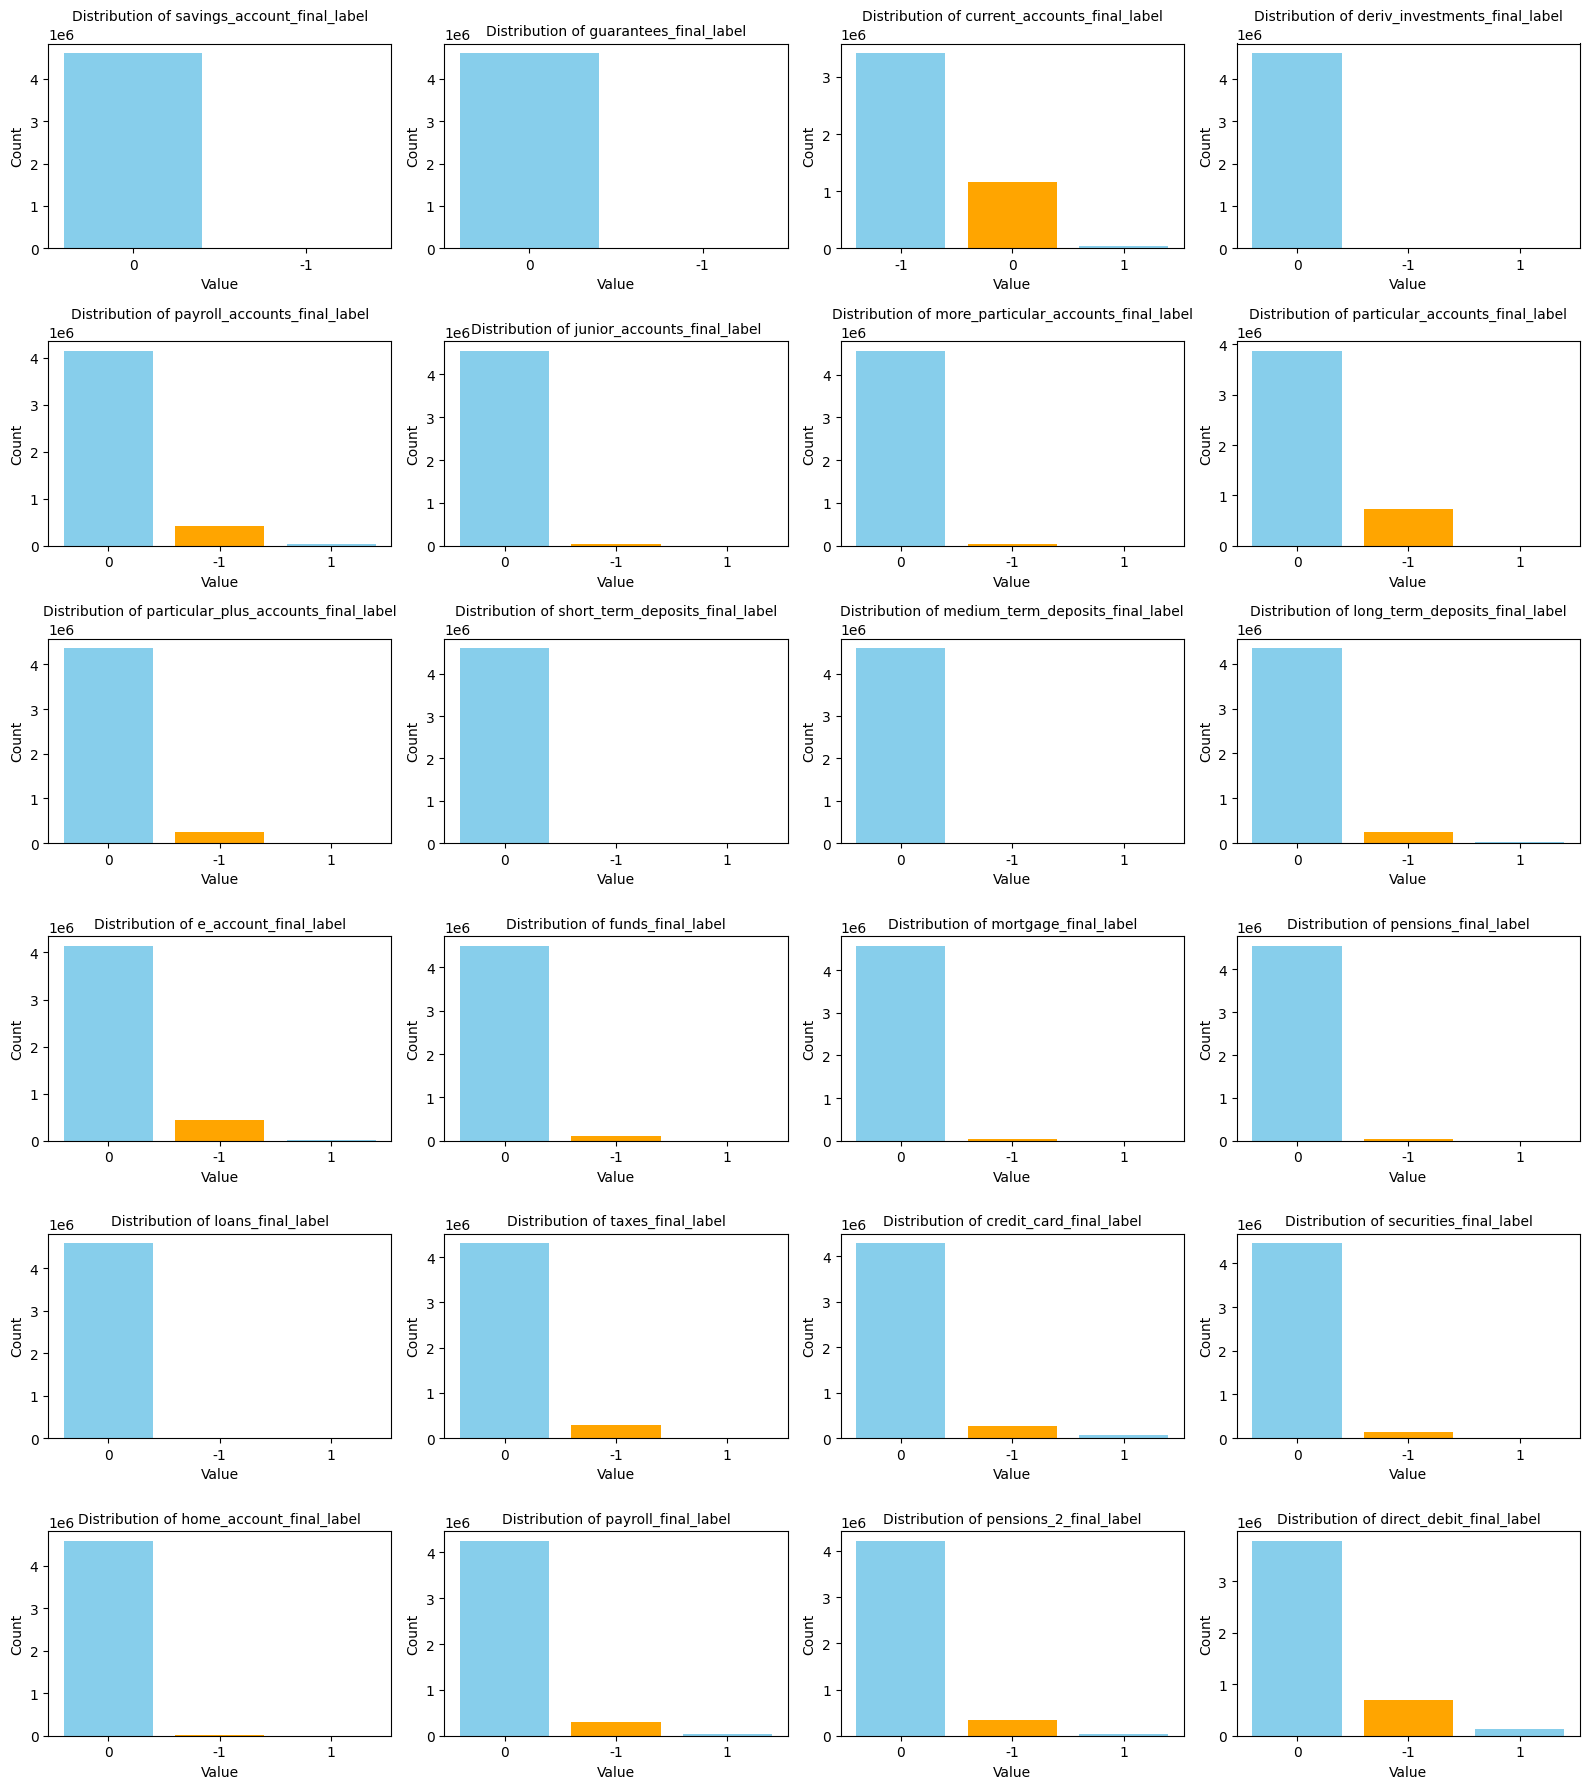

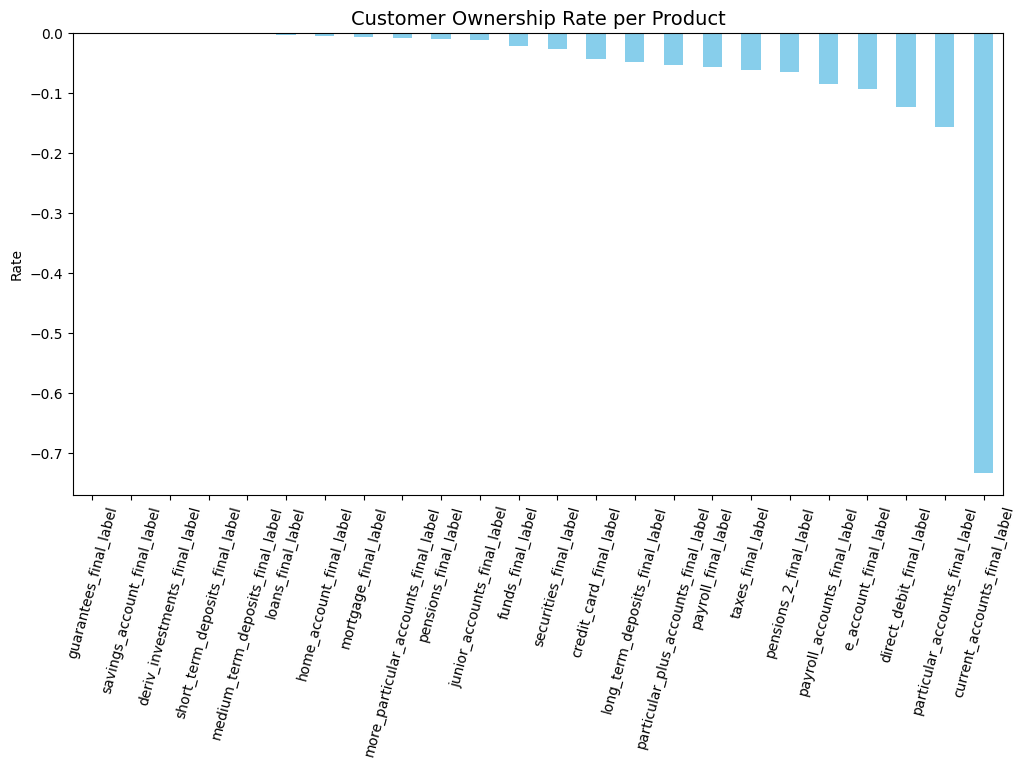

In [ ]:

import math

n_cols = 4
n_rows = math.ceil(len(target_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    counts = df[col].value_counts(dropna=False)
        axes[i].bar(counts.index.astype(str), counts.values, color=["skyblue", "orange"])
            axes[i].set_title(f"Distribution of {col}", fontsize=10)
                axes[i].set_xlabel("Value")
                    axes[i].set_ylabel("Count")
                        axes[i].tick_params(axis='x', rotation=0)

                        # Remove unused subplots if target count not divisible by n_cols
                        for j in range(i + 1, len(axes)):
                            fig.delaxes(axes[j])

                            plt.tight_layout()
                            plt.show()

                            # Plot ownership rates for all products
                            target_rates = df[target_cols].mean().sort_values(ascending=False)

                            plt.figure(figsize=(12, 6))
                            target_rates.plot(kind="bar", color="skyblue")
                            plt.title("Customer Ownership Rate per Product", fontsize=14)
                            plt.ylabel("Rate")
                            plt.xticks(rotation=75)
                            plt.show()
                            

### insight  

- Khách hàng có label 0 chiếm đa số. Tỉ lệ chuyển đổi của khách hàng từ không có sản phẩm qua có sản phẩm rất thấp 
- Dataset imbalanced -> **Resample dataset** 

## Employee Index

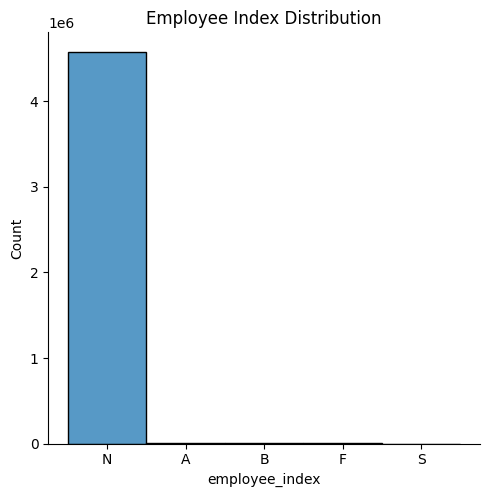

In [9]:
sns.displot(df['employee_index'])
plt.title('Employee Index Distribution')
plt.show()

**Insight**: Đa số khách hàng không phải là nhân viên của ngân hàng 


## Customer's Country residence

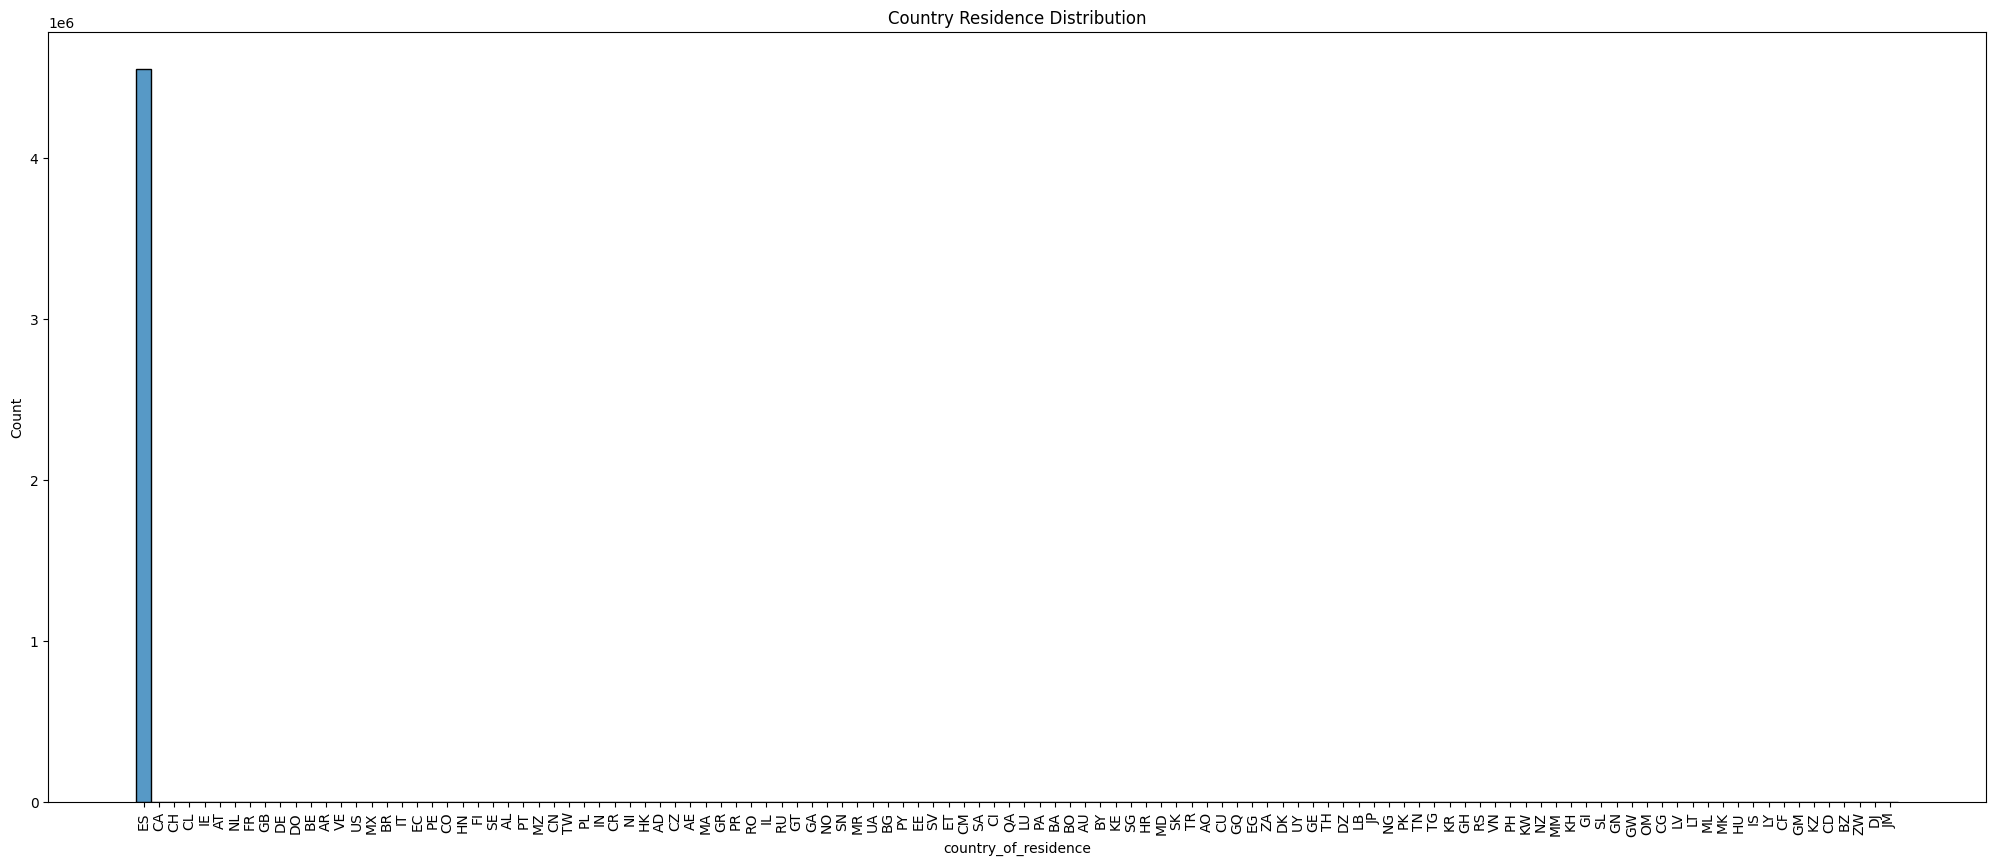

In [14]:
plt.figure(figsize=(25,10))
sns.histplot(df['country_of_residence'])
plt.title('Country Residence Distribution')
plt.xticks(rotation ='vertical')
plt.show()

*Insight:* Hầu hết khác hàng thuộc nước ES

## Gender

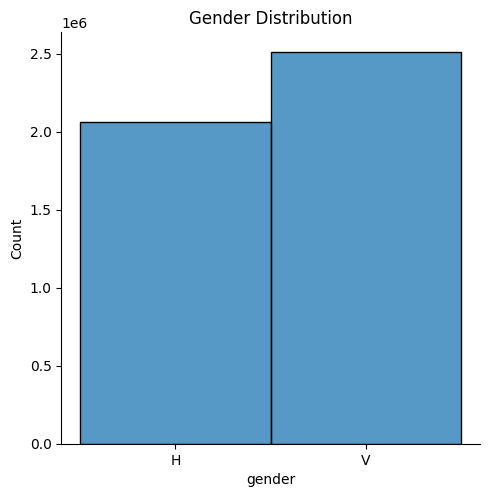

In [15]:
sns.displot(df['gender'])
plt.title('Gender Distribution')
plt.show()

*Insight:* Số khách hàng mang giới tính nữ nhiều hơn nam một chút. "V" là "Mujer", có nghĩa là nữ; còn "H" là "Hombre", có nghĩa là nam.

## Age

In [22]:


#  display distinct value of age 
df['age'].unique()

array([ 35.,  23.,  22.,  24.,  65.,  28.,  25.,  26.,  53.,  27.,  32.,
        37.,  31.,  39.,  63.,  33.,  55.,  42.,  58.,  38.,  50.,  30.,
        45.,  44.,  36.,  29.,  60.,  57.,  67.,  47.,  nan,  34.,  48.,
        46.,  54.,  84.,  15.,  12.,   8.,   6.,  83.,  40.,  77.,  69.,
        52.,  59.,  43.,  10.,   9.,  49.,  41.,  51.,  78.,  16.,  11.,
        73.,  62.,  66.,  17.,  68.,  82.,  95.,  96.,  56.,  61.,  79.,
        72.,  14.,  19.,  13.,  86.,  64.,  20.,  89.,  71.,   7.,  70.,
        74.,  21.,  18.,  75.,   4.,  80.,  81.,   5.,  76.,  92.,  93.,
        85.,  91.,  87.,  90.,  94.,  99.,  98.,  88.,  97., 100., 101.,
       106., 103.,   3.,   2., 102., 104., 111., 107., 109., 105., 112.,
       115., 110., 116., 108., 113.])

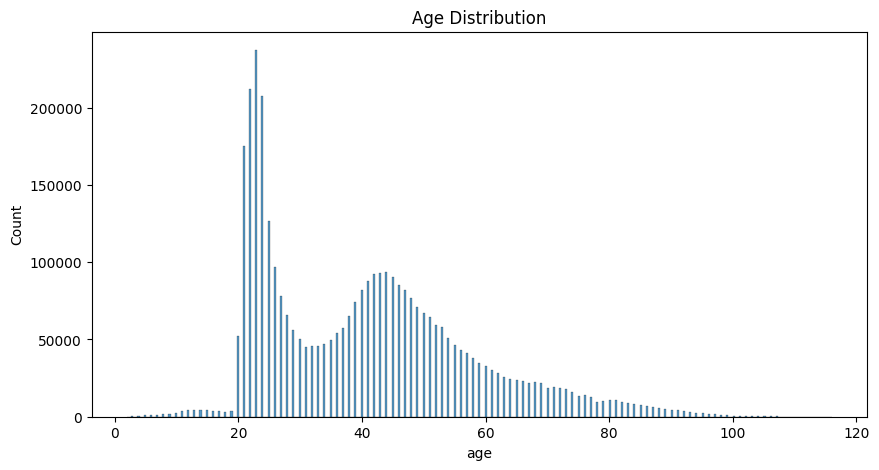

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'])
plt.title('Age Distribution')
plt.show()

*Insight*

- có rất ít khách hàng dưới 20 tuổi 
- Hầu hết khác hàng nằm trong độ tuổi từ 20-100, Tập trung nhiều nhất ở độ tuổi 20-25 

*Xử lí* : Group các nhóm khác hàng lại 20-30, 30-60 , 60+ 


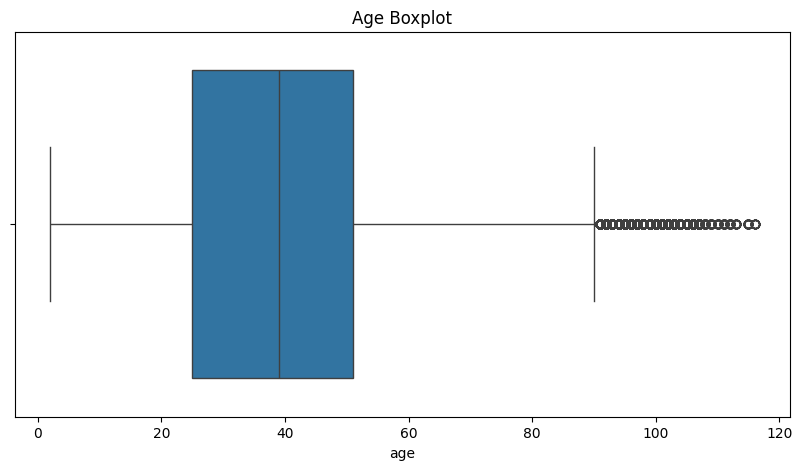

In [25]:
# Boxplot age
plt.figure(figsize=(10,5))
sns.boxplot(x=df['age'])
plt.title('Age Boxplot')
plt.show()

## Customer Seniority 

In [ ]:
df['seniority'].unique()


array(['      6', '     35', '     34', '     NA', '     33', '     31',
       '     21', '     16', '     27', '      9', '     22', '     13',
       '     29', '      8', '     11', '     10', '     28', '     24',
       '      7', '     25', '     14', '     26', '     12', '     23',
       '      1', '     18', '      4', '      3', '     17', '     32',
       '     30', '     20', '     15', '     19', '    157', '     36',
       '      5', '     40', '     38', '     37', '     39', '      0',
       '      2', '     47', '     44', '     42', '     46', '     45',
       '     43', '     41', '     57', '     48', '     52', '     49',
       '     50', '     56', '     58', '     51', '     55', '     54',
       '     53', '     59', '     62', '     61', '     60', '     63',
       '    139', '    165', '    118', '    164', '    142', '     94',
       '    159', '    143', '    105', '    151', '    162', '    137',
       '    150', '    128', '    122', '    156', 

- Có vài khách hàng có thời gian trung thành dưới 0 và nan

In [29]:
df['seniority'] = df['seniority'].str.strip()

# Bước 2: Thay 'NA' thành NaN
df['seniority'].replace('NA', pd.NA, inplace=True)

df['seniority'] = pd.to_numeric(df['seniority'], errors='coerce')

df.loc[df['seniority'] == -999999, 'seniority'] = pd.NA


print(df['seniority'].unique())


C:\Users\LEGION\AppData\Local\Temp\ipykernel_12956\2561650804.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['seniority'].replace('NA', pd.NA, inplace=True)


[  6.  35.  34.  nan  33.  31.  21.  16.  27.   9.  22.  13.  29.   8.
  11.  10.  28.  24.   7.  25.  14.  26.  12.  23.   1.  18.   4.   3.
  17.  32.  30.  20.  15.  19. 157.  36.   5.  40.  38.  37.  39.   0.
   2.  47.  44.  42.  46.  45.  43.  41.  57.  48.  52.  49.  50.  56.
  58.  51.  55.  54.  53.  59.  62.  61.  60.  63. 139. 165. 118. 164.
 142.  94. 159. 143. 105. 151. 162. 137. 150. 128. 122. 156. 119. 160.
  79.  95. 132. 161.  98. 127.  72. 155. 108. 163. 102. 148. 115. 146.
 107.  81. 216. 135.  92. 121. 198. 134.  93. 140. 110. 120. 147. 116.
  64.  77.  85.  99.  78. 100. 113. 154. 166. 133. 124. 141.  66. 117.
  86. 193.  80. 144.  87. 126. 158. 101. 235.  88. 145. 103. 149. 109.
 131.  97.  68.  84. 232. 125. 177. 112.  96.  69. 171. 167. 104.  76.
  82. 152.  70. 138. 169.  65. 129. 190. 114. 111. 176. 153.  89. 136.
  83. 123. 187. 106. 231. 189. 217. 172. 199. 173. 174. 209. 180. 178.
  91. 168. 130. 225.  67.  73. 183.  74. 206.  71. 179. 184. 192.  90.
 194. 

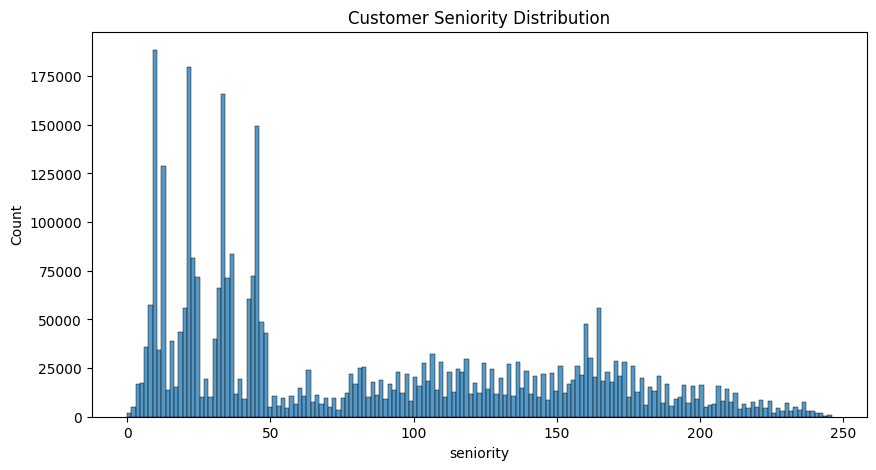

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(df['seniority'])
plt.title('Customer Seniority Distribution')
plt.ticklabel_format(useOffset=False,style = 'plain',axis = 'x')
plt.show()

## Primary customer

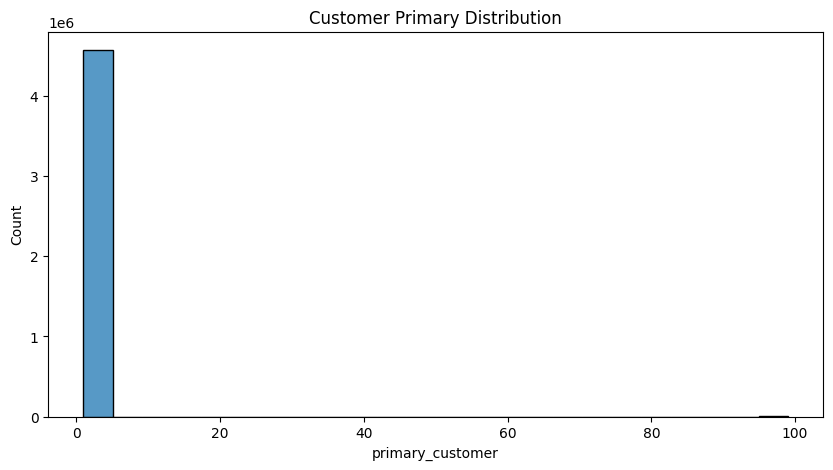

In [34]:
# histogram
plt.figure(figsize=(10,5))
sns.histplot(df['primary_customer'])
plt.title('Customer Primary Distribution')
plt.ticklabel_format(useOffset=False,style = 'plain',axis = 'x')
plt.show()


In [35]:
df['primary_customer'].unique()

array([ 1., nan, 99.])

1 = Primary customer tại thời điểm snapshot.

99 = Đã từng primary trong tháng nhưng snapshot cuối tháng không còn là primary.

Đa số các khách hàng tại thời điểm snapshot đều là primary customer và rất ít khách hàng không còn primary 

## Residence index

In [13]:
df['residence_index'] = pd.to_numeric(df['residence_index'], errors='coerce')

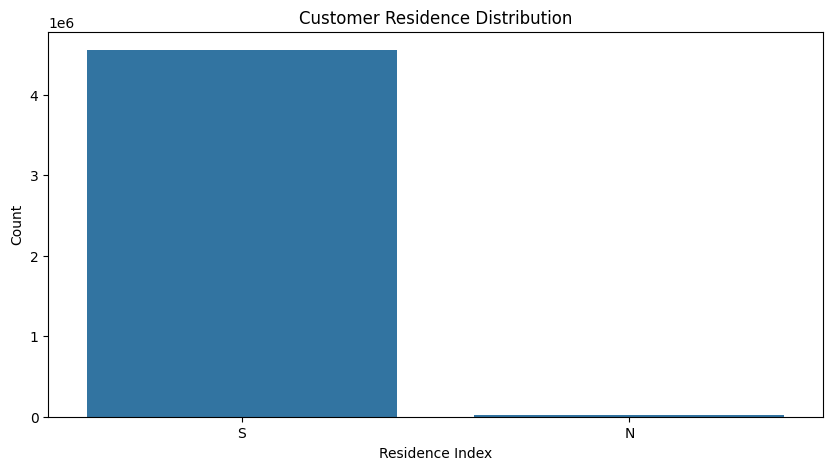

In [18]:

plt.figure(figsize=(10,5))
sns.countplot(x='residence_index', data=df)
plt.title('Customer Residence Distribution')
plt.xlabel('Residence Index')
plt.ylabel('Count')
plt.show()


Hầu hết các khách hàng có nơi cư trú là nước sở tại của ngân hàng

In [16]:
df['residence_index'].unique()

array(['S', nan, 'N'], dtype=object)

## foreigner_index

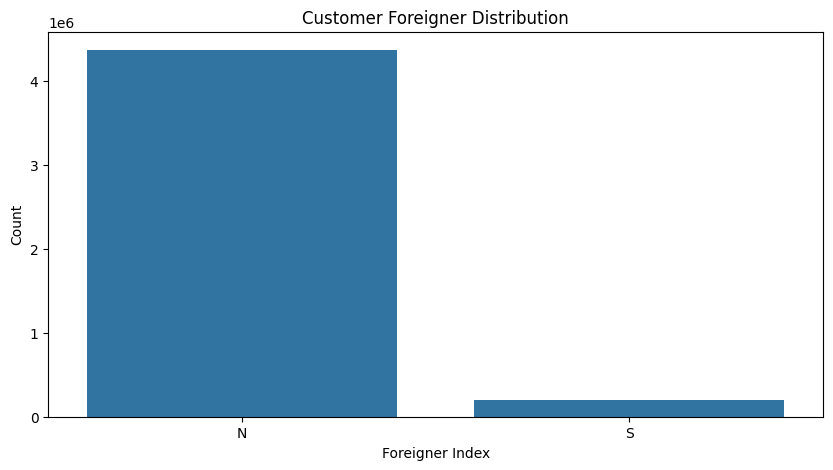

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='foreigner_index', data=df)
plt.title('Customer Foreigner Distribution')
plt.xlabel('Foreigner Index')
plt.ylabel('Count')
plt.show()

 Hầu hết các khách hàng có nơi sinh là nước sở tại của ngân hàng

## spouse_index

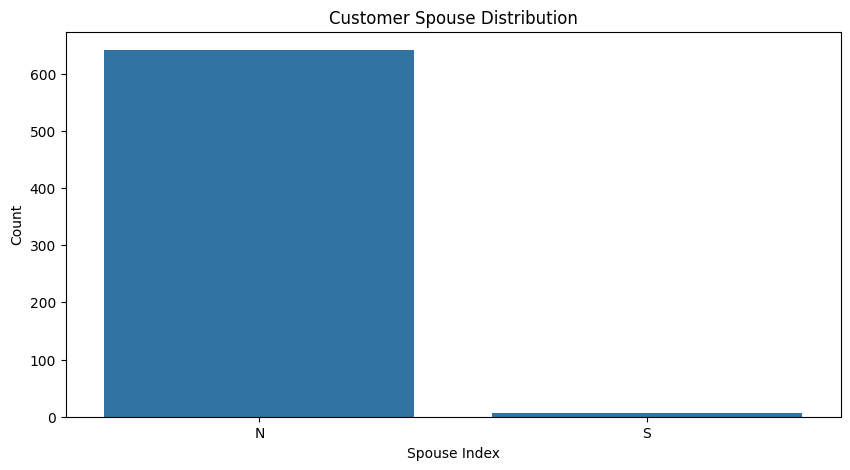

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x='spouse_index', data=df)
plt.title('Customer Spouse Distribution')
plt.xlabel('Spouse Index')
plt.ylabel('Count')
plt.show()

 Hầu hết khách hàng không phải là vợ/chồng của một nhân viên

## channel 

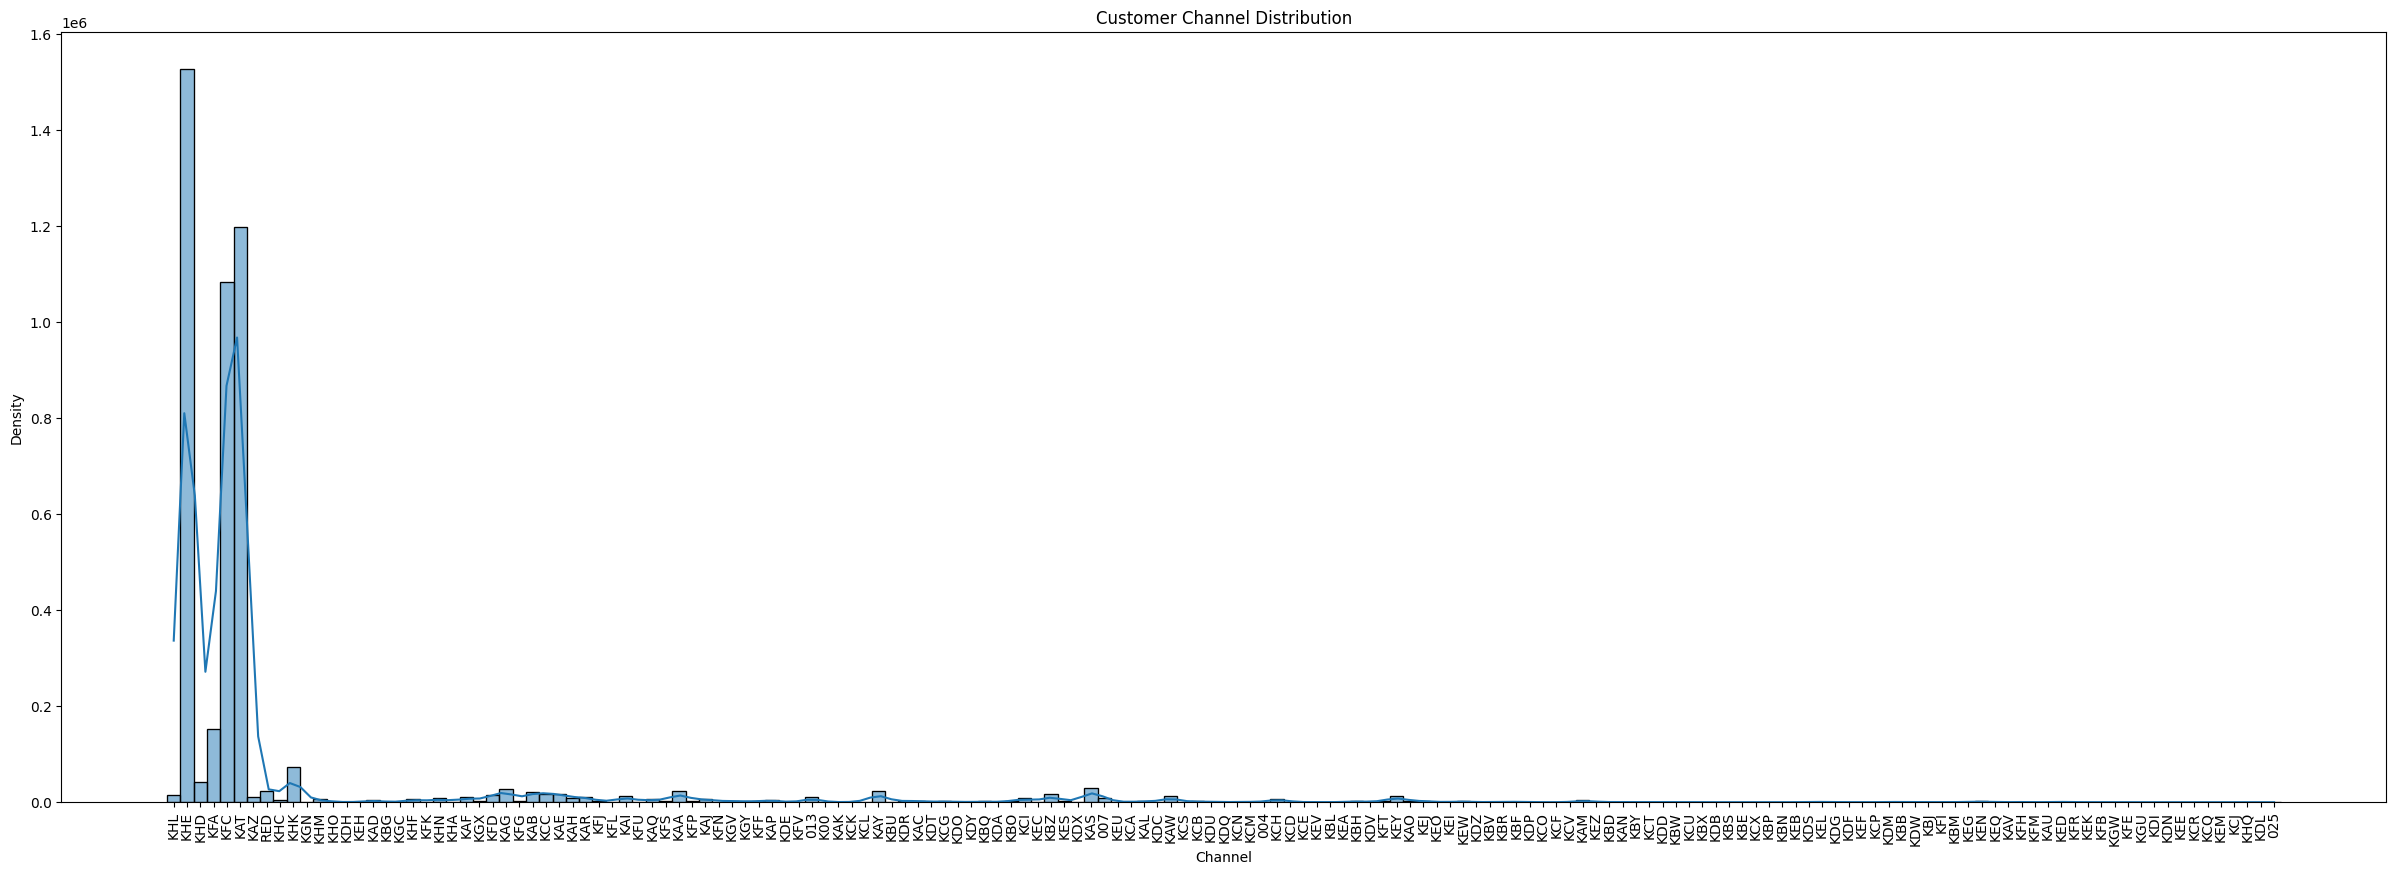

In [25]:
# hist
plt.figure(figsize=(30,10))
sns.histplot(df['channel'], bins=30, kde=True )
plt.title('Customer Channel Distribution')
plt.xlabel('Channel')
plt.ylabel('Density')
plt.xticks(rotation ='vertical')
plt.show()

Đa số khách hàng tham gia bank qua các kênh 'KHE', 'KAT', 'KFC' và 'KHO'

KHE → quầy giao dịch trực tiếp tại chi nhánh chính hoặc chi nhánh lớn.

KAT → kênh qua đối tác hoặc chi nhánh phụ.

KFC → kênh qua cộng tác viên/đại lý môi giới.

KHO → kênh online hoặc hotline đăng ký

## deceased_index 

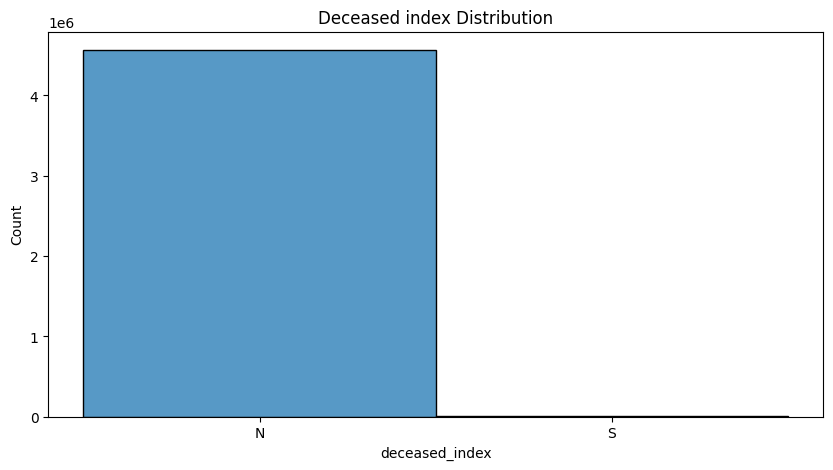

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(df['deceased_index'])
plt.title('Deceased index Distribution')
plt.show()

Hầu hết các khách hàng chưa qua đời

## province_name

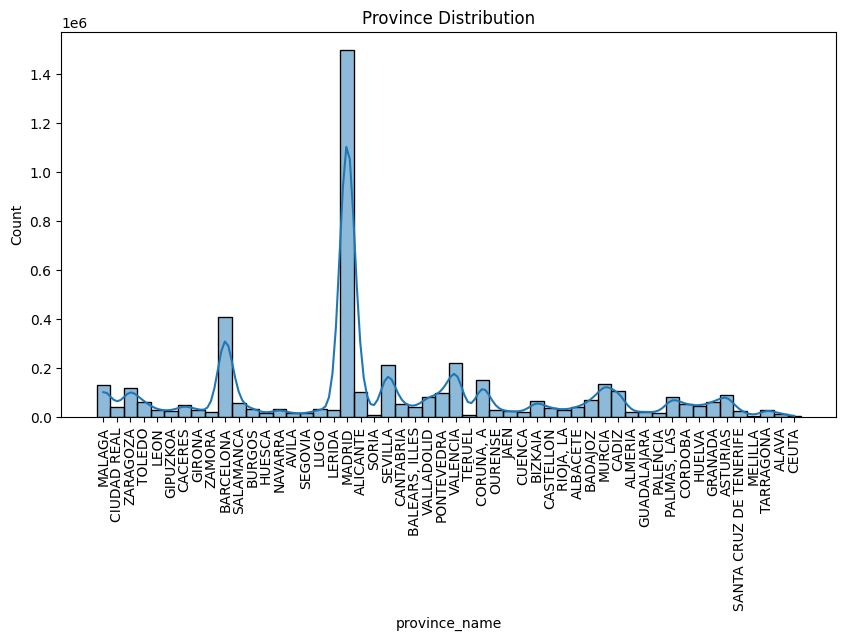

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(df['province_name'], bins=30, kde=True)
plt.title('Province Distribution')
plt.xticks(rotation ='vertical')
plt.show()


Hầu hết khách hàng đến từ hai thành phố là 'MADRID' và 'BARCELONA'

In [ ]:
df['province_name'].unique()

array([29., 13., 50., 45., 24., 20., 10., 17., 49.,  8., 37.,  9., 22.,
       31.,  5., 40., 27., 25., 28.,  3., 42., 41., 39.,  7., 47., 36.,
       46., 44., 15., 32., 23., 16., 48., 12., 26.,  2.,  6., 30., 11.,
       nan,  4., 19., 34., 35., 14., 21., 18., 33., 38., 52., 43.,  1.,
       51.])

## Segment

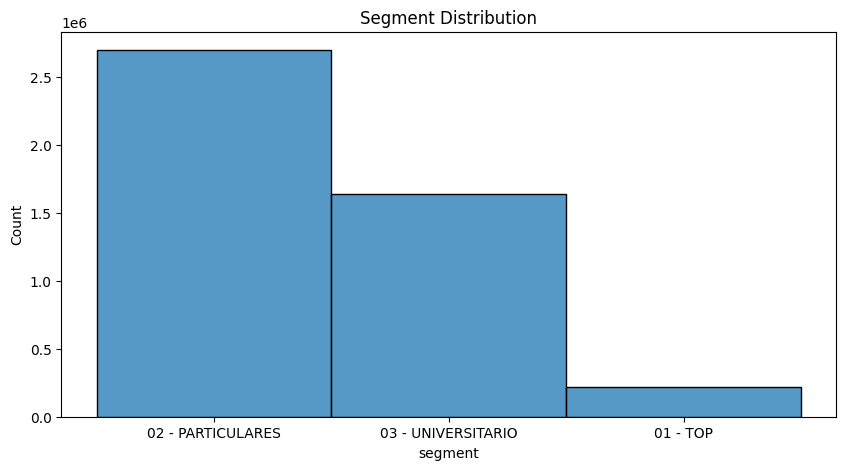

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(df['segment'])
plt.title('Segment Distribution')
plt.show()

Hầu hết khách hàng thuộc loại individuals và college graduated.

Có rất ít khách hàng VIPs

# Multivariate Analysis

In [16]:
import pandas as pd
product_cols = [
    "savings_account_final_label",
    "guarantees_final_label",
    "current_accounts_final_label",
    "deriv_investments_final_label",
    "payroll_accounts_final_label",
    "junior_accounts_final_label",
    "more_particular_accounts_final_label",
    "particular_accounts_final_label",
    "particular_plus_accounts_final_label",
    "short_term_deposits_final_label",
    "medium_term_deposits_final_label",
    "long_term_deposits_final_label",
    "e_account_final_label",
    "funds_final_label",
    "mortgage_final_label",
    "pensions_final_label",
    "loans_final_label",
    "taxes_final_label",
    "credit_card_final_label",
    "securities_final_label",
    "home_account_final_label",
    "payroll_final_label",
    "pensions_2_final_label",
    "direct_debit_final_label"
]

count_list = []
for col in product_cols:
    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    count_list.append({
        "product": col,
        "-1_count": counts.get(-1, 0),
        "-1_pct": counts.get(-1, 0) / total * 100,
        "0_count": counts.get(0, 0),
        "0_pct": counts.get(0, 0) / total * 100,
        "1_count": counts.get(1, 0),
        "1_pct": counts.get(1, 0) / total * 100
    })

product_stats = pd.DataFrame(count_list).sort_values(by="1_pct", ascending=False)
pd.set_option('display.float_format', lambda x: f"{x:.2f}")
product_stats


,product,-1_count,-1_pct,0_count,0_pct,1_count,1_pct
23,direct_debit_final_label,691019,15.00,3792689,82.34,122603,2.66
18,credit_card_final_label,258739,5.62,4286328,93.05,61244,1.33
21,payroll_final_label,309895,6.73,4252015,92.31,44401,0.96
22,pensions_2_final_label,342193,7.43,4219835,91.61,44283,0.96
2,current_accounts_final_label,3415541,74.15,1152619,25.02,38151,0.83
4,payroll_accounts_final_label,425889,9.25,4149330,90.08,31092,0.67
11,long_term_deposits_final_label,241004,5.23,4345655,94.34,19652,0.43
12,e_account_final_label,449602,9.76,4142517,89.93,14192,0.31
19,securities_final_label,137593,2.99,4457980,96.78,10738,0.23
17,taxes_final_label,291618,6.33,4307714,93.52,6979,0.15


## TYPE_I

current_accounts_final_label — Tài khoản thanh toán thường

payroll_accounts_final_label — Tài khoản nhận lương

junior_accounts_final_label — Tài khoản dành cho trẻ em/thanh thiếu niên

more_particular_accounts_final_label — Tài khoản chuyên biệt hơn

particular_accounts_final_label — Tài khoản cá nhân

particular_plus_accounts_final_label — Tài khoản cá nhân nâng cao

e_account_final_label — Tài khoản điện tử

home_account_final_label — Tài khoản liên quan chi tiêu gia đình

payroll_final_label — Sản phẩm chi trả lương qua ngân hàng

In [14]:
type1 = [
    "current_accounts_final_label",
    "payroll_accounts_final_label",
    "junior_accounts_final_label",
    "more_particular_accounts_final_label",
    "particular_accounts_final_label",
    "particular_plus_accounts_final_label",
    "e_account_final_label",
    "home_account_final_label",
    "payroll_final_label"
]


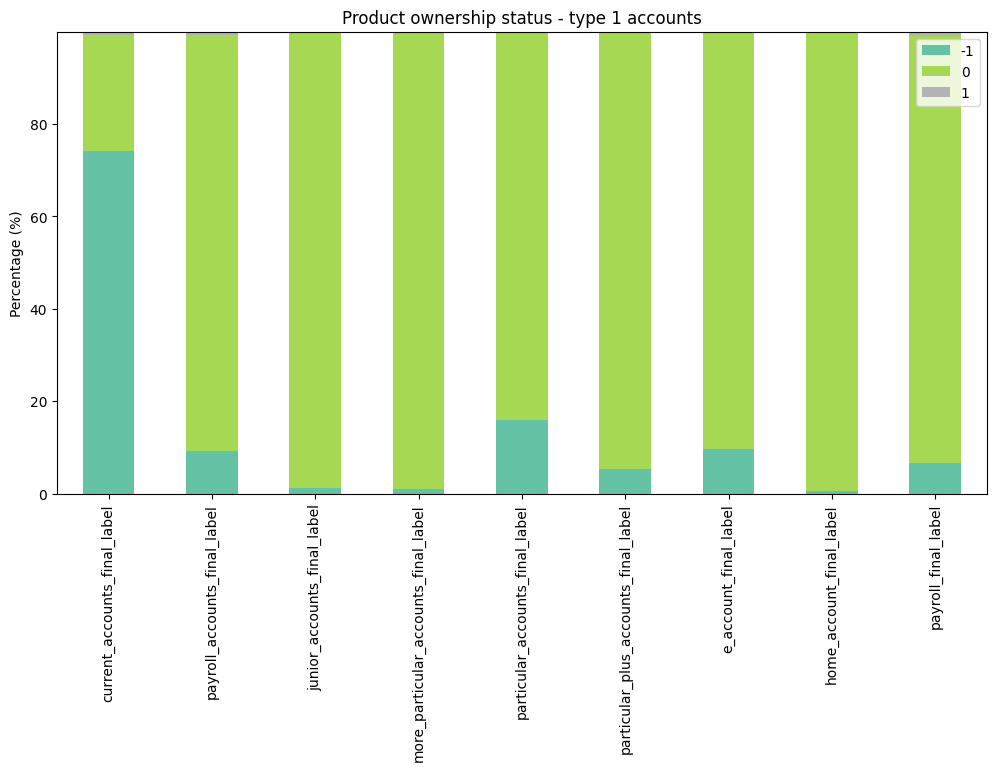

In [18]:
status_counts = {}
for col in type1:
    counts = df[col].value_counts(normalize=True) * 100
    status_counts[col] = counts

status_df = pd.DataFrame(status_counts).T.fillna(0)

status_df = status_df.reindex(columns=[-1, 0, 1], fill_value=0)

status_df.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.ylabel("Percentage (%)")
plt.title("Product ownership status - type 1 accounts")
plt.show()


Ở các loại sản phẩm trong type I đều có tỉ lệ mở thêm tài khoản rất ít 

Đa số các loại sản phẩm đều chưa sở hữu bởi người dùng và có xu hướng không mở thêm

Current_account, đa số người dùng đã mở sẵn (chiếm hơn 70%)

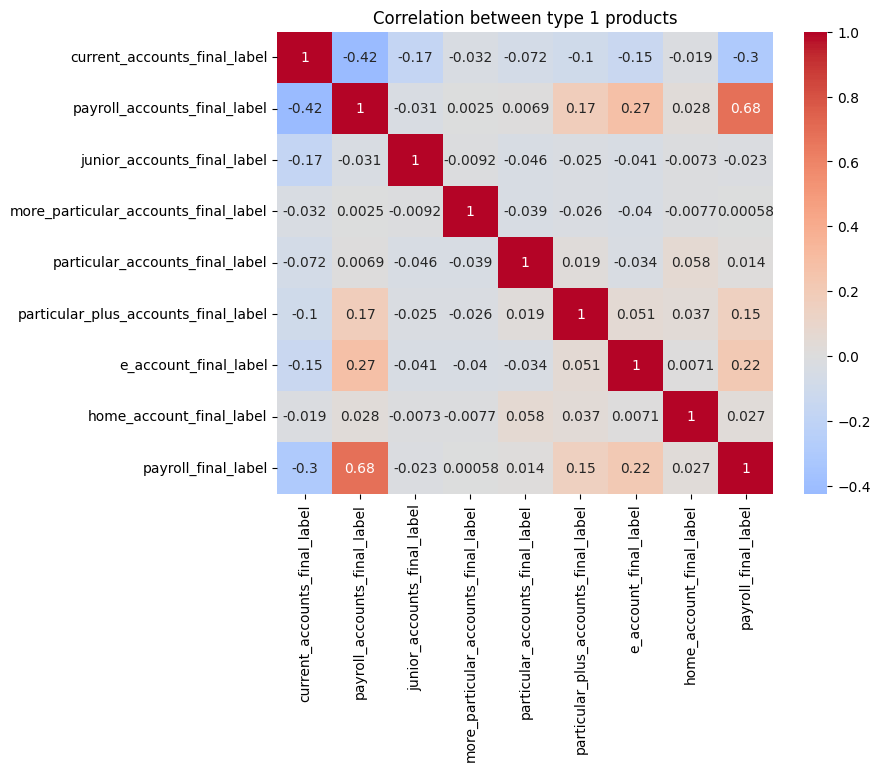

In [19]:
corr = df[type1].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between type 1 products")
plt.show()


Payroll và payroll account thường đi với nhau 

- đa só khách hàng đã nắm giữ sẵn 1 loại sản phẩm nào đó rồi 